## imports

In [2]:
import os

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import Tensor
from torch.nn import functional

from train import Mode, ModelManager, DIR_ROOT_SAVE
from utils import plot_img_and_top, get_loader, get_cifar100

# globals
NUM_CLASSES = 100
BATCH_SIZE = 5
NUM_TRAIN = 10
NUM_TEST = 10
PRUNE_EPOCHS = 6

NOTEBOOK_NAME = 'forget'
# PATH_NOTEBOOK_SAVED_DATA = os.path.join(DIR_ROOT_SAVE, NOTEBOOK_NAME, 'general.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar100()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

C:\Users\ProjectUser\Documents\Data-pruning\models_data\forget\general.pt
train on: cuda
Files already downloaded and verified
Files already downloaded and verified


In [4]:
epochs_pred = torch.empty((PRUNE_EPOCHS, NUM_TRAIN), dtype=torch.int8)
change_counter = torch.zeros(NUM_TRAIN, dtype=torch.int8)

model_manager = ModelManager(NUM_CLASSES, 'forgetting', load=False)
loss_train, loss_valid, acc_train, acc_valid = [], [], [], []
model_manager.model.to(ModelManager.DEVICE)
for epoch in range(PRUNE_EPOCHS):
    model_manager.model.to(ModelManager.DEVICE)
    train_res = model_manager.run_epoch(loader_train, Mode.TRAIN)
    valid_res = model_manager.run_epoch(loader_test, Mode.VALIDATE)
    loss_train.append(train_res[2]), loss_valid.append(valid_res[2])
    acc_train.append(train_res[3]), acc_valid.append(valid_res[3])
    s = f'Epoch: {epoch} Training: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  ' \
        f'Validation Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}  '

    train_res = model_manager.run_epoch(loader_train_ordered, Mode.TEST)
    epochs_pred[epoch] = train_res[1].detach().clone()
    if epoch:
        changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
        changes_mean = changes.type(torch.float64).mean()
        model_manager.tb.add_scalar('changes_mean', changes_mean, epoch)
        change_counter += changes
        s += f'Changes {changes_mean:.2%}'

    print(s), model_manager.model.cpu()
    model_manager.epochs += 1
    model_manager.scheduler.step()

model_manager.save_model()
model_manager.data['train']['loss'] += loss_train
model_manager.data['train']['acc'] += acc_train
model_manager.data['valid']['loss'] += loss_valid
model_manager.data['valid']['acc'] += acc_valid
model_manager.save_data(data_other={'epochs_pred': epochs_pred, 'change_counter': change_counter})

Epoch: 0 Training: Loss: 0.928906 Acc: 0.000000  Validation Loss: 0.918203 Acc: 0.100000                                               
Epoch: 1 Training: Loss: 0.851406 Acc: 0.000000  Validation Loss: 4.172188 Acc: 0.000000  Changes 100.00%                            
Epoch: 2 Training: Loss: 0.667012 Acc: 0.300000  Validation Loss: 179.676093 Acc: 0.000000  Changes 20.00%                                
Epoch: 3 Training: Loss: 0.599619 Acc: 0.300000  Validation Loss: 192.980933 Acc: 0.000000  Changes 0.00%                                 
Epoch: 4 Training: Loss: 0.619746 Acc: 0.300000  Validation Loss: 243.920624 Acc: 0.000000  Changes 0.00%                                
Epoch: 5 Training: Loss: 0.468113 Acc: 0.400000  Validation Loss: 192.102496 Acc: 0.000000  Changes 0.00%                                


In [5]:
model_manager = ModelManager(NUM_CLASSES, 'forgetting', load=True)
change_counter = model_manager.data_other['change_counter']
epochs_pred = model_manager.data_other['epochs_pred']

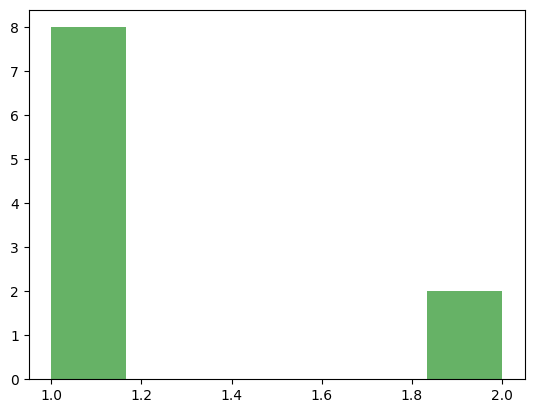

In [6]:
plt.hist(change_counter, bins=PRUNE_EPOCHS, facecolor='g', alpha=0.6)
plt.show()

In [7]:
model_manager.model.to(ModelManager.DEVICE)
scores, _, _, _ = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
model_manager.model.cpu()
scores = scores.cpu()
# plot_prune_example(data_train_raw, change_counter, hardest=True, random=False, prune_method_name='Forgetting')
# plot_prune_example(data_train_raw, change_counter, hardest=False, random=False, prune_method_name='Forgetting')

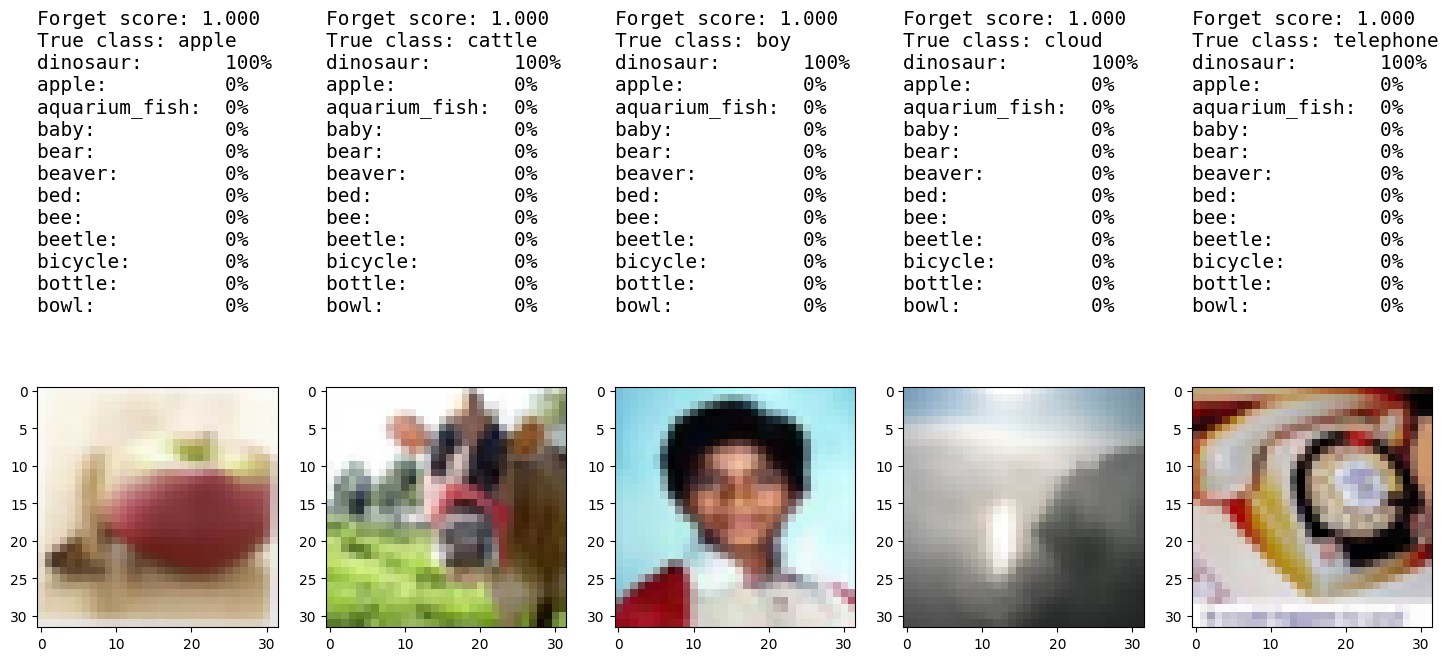

In [8]:
plot_img_and_top(dataset_train_raw, (.0, 1.), change_counter, functional.softmax(scores, dim=1), score_name='Forget')

In [7]:
# dataset_train, dataset_test = get_cifar(PATH_DATASETS)
# loader_test = get_loader(dataset_test, np.arange(NUM_TEST), BATCH_SIZE, False)
# idx_sorted_to_train = change_counter.sort()[1].numpy()

# 1. every 2 epochs add the next group of hard to dataset

In [8]:

# model_manager = ModelManager(NUM_CLASSES, 'forgetting_simple_to_hard', load=False)
#
# idx = np.array([], dtype=int)
# print()
# for i in range(PRUNE_EPOCHS):
#     print(f'====     Add example with counter {i} to dataset     ======')
#     idx = np.append(idx, Tensor(change_counter == i).nonzero()[:, 0].numpy())
#     if not len(idx):
#         print(f'no example with change_counter={i}\n')
#         continue
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#     model_manager.train(loader_train, loader_test, loader_test, 4)
#     print()

# 2. same as 1 but remove 50% of last group

In [9]:
# model_manager = ModelManager(NUM_CLASSES, 'forgetting_simple_to_hard_50p', load=False)
#
# idx = np.array([], dtype=int)
# print()
# for i in range(PRUNE_EPOCHS):
#     print(f'====     Add example with counter {i} to dataset     ======')
#
#     if i:
#         last_idx = Tensor(change_counter == (i - 1)).nonzero()[:, 0].numpy()
#         idx = np.append(idx, np.random.choice(last_idx, len(last_idx) // 2, replace=False))
#
#     curr_idx = np.append(idx, Tensor(change_counter == i).nonzero()[:, 0].numpy())
#     if not len(curr_idx):
#         print(f'no example with change_counter={i}\n')
#         continue
#
#     loader_train = get_loader(dataset_train, curr_idx, BATCH_SIZE, True)
#     model_manager.train(loader_train, loader_test, loader_test, 4)
#
#     print()

# 3. train only 50% of the simplest examples


In [10]:
# model_manager = ModelManager(NUM_CLASSES, 'forgetting_easiest', load=False)
#
# loader_train = get_loader(dataset_train, idx_sorted_to_train[:NUM_TRAIN // 2], BATCH_SIZE, True)
# print()
# model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

# 4. train 9 models each with 10% less easy train examples

In [11]:
# models = []
#
# idx = np.array([], dtype=int)
# print()
# loss, acc, prune_size = [], [], []
#
# for subset in np.array_split(idx_sorted_to_train, 10):
#     idx = np.append(idx, subset)
#     prcent = len(idx) / NUM_TRAIN
#     print(f'====     train model with {prcent:.0%} most hard     ======')
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#
#     model_manager = ModelManager(NUM_CLASSES, f'forgetting_{int(prcent * 100)}p_hard', dir_='forgetting_p_hard',
#                                  load=False)
#     model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
#
#     models.append(model_manager)
#     prune_size.append(prcent), acc.append(model_manager.data['test']['acc']), loss.append(
#         model_manager.data['test']['loss'])
#     print()
#
# ModelManager.save_models_log(models, 'forgetting_p_hard')

In [12]:
# fig, axes = plt.subplots(1, 2, figsize=(17, 4))
# axes[0].plot(prune_size, loss)
# axes[0].set_xlabel('prune size')
# axes[0].set_ylabel('Loss')
# axes[1].plot(prune_size, acc)
# axes[1].set_xlabel('prune size')
# axes[1].set_ylabel('Acc')
# fig.subplots_adjust(wspace=.4)
# plt.plot()

# 5.

In [13]:
# models = []
#
# idx = np.array([], dtype=int)
# print()
# loss, acc, prune_size = [], [], []
#
# for subset in np.array_split(idx_sorted_to_train[::-1], 10):
#     idx = np.append(idx, subset)
#     prcent = len(idx) / NUM_TRAIN
#     print(f'====     train model with {prcent:.0%} most hard     ======')
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#
#     model_manager = ModelManager(NUM_CLASSES, f'forgetting_{int(prcent * 100)}p_hard_', dir_='forgetting_p_hard_',
#                                  load=False)
#     model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
#
#     models.append(model_manager)
#     prune_size.append(prcent), acc.append(model_manager.data['test']['acc']), loss.append(
#         model_manager.data['test']['loss'])
#     print()
#
# ModelManager.save_models_log(models, 'forgetting_p_hard_')
#
# fig, axes = plt.subplots(1, 2, figsize=(17, 4))
# axes[0].plot(prune_size, loss)
# axes[0].set_xlabel('prune size')
# axes[0].set_ylabel('Loss')
# axes[1].plot(prune_size, acc)
# axes[1].set_xlabel('prune size')
# axes[1].set_ylabel('Acc')
# fig.subplots_adjust(wspace=.4)
# plt.plot()